In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Method 1 = include_motif_information = 1
# Method 2 = include_motif_information = 2 (Pairwise Diff)

files = {
    'Electricity': {
        1: 'grid_search_electricity_results_[True, False]_True_[1]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv',
        2: 'grid_search_electricity_results_[True, False]_True_[2]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv'
    },
    'Traffic': {
        1: 'grid_search_traffic_results_[True, False]_True_[1]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv',
        2: 'grid_search_traffic_results_[True, False]_True_[2]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv'
    },
    'PeMSD7': {
        1: 'grid_search_pems_results_[True, False]_True_[1]_[1]_[1, 2, 3, 5, 9]_[True, False]_[True, False].csv',
        2: 'grid_search_pems_results_[True, False]_True_[2]_[1]_[1, 2, 3, 5, 9]_[True, False]_[True, False].csv'
    },
    'Exchange-Rate': {
        1: 'grid_search_exchange_rate_results_[True, False]_True_[1]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv',
        2: 'grid_search_exchange_rate_results_[True, False]_True_[2]_[1]_[1, 2, 6, 12, 24]_[True, False]_[True, False].csv'
    }
}

# ---------------------------------------------------------
base_path = '../results/local_daikon/'
dfs = []
metrics = ['RMSE', 'WAPE', 'MAE']

for ds_name, methods in files.items():
    for method_id, fname in methods.items():
        full_path = os.path.join(base_path, fname)
        if os.path.exists(full_path):
            df = pd.read_csv(full_path)
            df['dataset'] = ds_name
            df['method_id'] = method_id # 1 or 2
            
            # Use only Unnormalized data
            if 'do_normalization' in df.columns:
                df = df[df['do_normalization'] == False]
            
            # Keep only necessary columns to avoid merge conflicts
            cols = ['dataset', 'method_id'] + metrics + \
                   ['include_covariates', 'include_similarity', 'no_points_after_motif']
            dfs.append(df[cols])
        else:
            print(f"Warning: File not found {full_path}")

all_df = pd.concat(dfs, ignore_index=True)
# print(all_df.head())

In [2]:
# Pivot table to put Method 1 and Method 2 side-by-side for the same config
# We match on Dataset, Covariates, Similarity, and Points
match_cols = ['dataset', 'include_covariates', 'include_similarity', 'no_points_after_motif']

pivot_df = all_df.pivot_table(index=match_cols, columns='method_id', values=metrics)
pivot_df.dropna(inplace=True) 
# print(pivot_df.head())

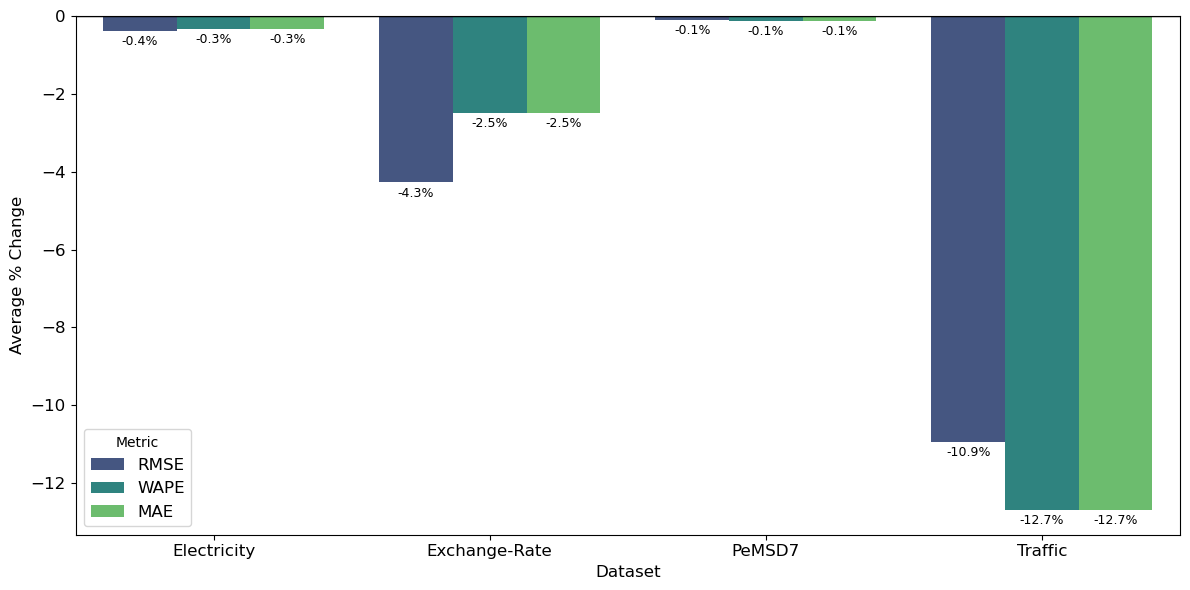

In [3]:
# Calculate Improvement: (M1 - M2) / M1 * 100
calc_df = pd.DataFrame(index=pivot_df.index)
for m in metrics:
    calc_df[m] = (pivot_df[(m, 1)] - pivot_df[(m, 2)]) / pivot_df[(m, 1)] * 100

# Reset index so 'dataset' and others become columns
calc_df = calc_df.reset_index()

# Average by Dataset and Metric
avg_imp = calc_df.groupby('dataset')[metrics].mean().reset_index()

# Melt the dataframe to long format for plotting with hue
melted_imp = avg_imp.melt(id_vars='dataset', value_vars=metrics, var_name='Metric', value_name='pct_improvement')

plt.figure(figsize=(12, 6))
# Using a Red-Blue colormap or similar to distinguish metrics
sns.barplot(data=melted_imp, x='dataset', y='pct_improvement', hue='Metric', palette='viridis')

plt.axhline(0, color='black', linewidth=1)
# plt.ylabel('Average % Improvement\n(Negative = Method 2 increases error)', fontsize=12)
plt.ylabel('Average % Change', fontsize='large')
plt.xlabel('Dataset', fontsize='large')
# plt.title('Performance Impact of Using Pairwise Differences (All Metrics)', fontsize=14, fontweight='bold')
plt.legend(title='Metric', fontsize='large')
plt.tick_params(axis='both', labelsize='large')

# Add text labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('../figures/raw_vs_pairwise.pdf')
# plt.savefig('performance_loss_bar_all_metrics.png', dpi=300)
plt.show()

In [4]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")

This notebook was last run end-to-end on: 2026-01-24 16:26:12.931232

